In [14]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick

In [15]:
stats = pd.read_csv('stats')

In [16]:
stats

,video-name,low-resolution,high-resolution,low_qp,high_qp,batch-size,low-threshold,high-threshold,tracker-length,TP,FP,FN,F1,low-size,high-size,total-size,frames,mode
0,results/rene-25-3_gt,1.0,-1.0,24,-1,5,0.5,0.8,4,0,0,0,0.000,1468207,0,1468207,25,mpeg
1,results/rene-25-3_mpeg_1.0_24,1.0,-1.0,24,-1,5,0.5,0.8,4,179,0,0,1.000,1468207,0,1468207,25,mpeg
2,results/rene-25-3_mpeg_0.8_24,0.8,-1.0,24,-1,5,0.5,0.8,4,143,41,31,0.799,1024396,0,1024396,25,mpeg
3,results/rene-25-3_mpeg_0.7_24,0.7,-1.0,24,-1,5,0.5,0.8,4,87,49,92,0.552,821926,0,821926,25,mpeg
4,results/rene-25-3_mpeg_0.6_24,0.6,-1.0,24,-1,5,0.5,0.8,4,113,36,62,0.698,690351,0,690351,25,mpeg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,results/rene-25-3_dds_0.4_1.0_34_28_0.0_twosid...,0.4,1.0,34,28,5,0.5,0.8,4,96,129,82,0.476,175912,284013,459925,25,emulation
491,results/rene-25-3_dds_0.5_1.0_34_28_0.0_twosid...,0.5,1.0,34,28,5,0.5,0.8,4,103,89,76,0.555,237330,186776,424106,25,emulation
492,results/rene-25-3_dds_0.6_1.0_34_28_0.0_twosid...,0.6,1.0,34,28,5,0.5,0.8,4,112,56,72,0.636,291592,199966,491558,25,emulation
493,results/rene-25-3_dds_0.7_1.0_34_28_0.0_twosid...,0.7,1.0,34,28,5,0.5,0.8,4,111,64,63,0.636,335873,267804,603677,25,emulation


In [17]:
stats_dds = stats[stats['mode'] == 'emulation']

In [18]:
stats_dds

,video-name,low-resolution,high-resolution,low_qp,high_qp,batch-size,low-threshold,high-threshold,tracker-length,TP,FP,FN,F1,low-size,high-size,total-size,frames,mode
36,results/rene-25-3_dds_0.1_0.2_30_24_0.0_twosid...,0.1,0.2,30,24,5,0.5,0.8,4,3,14,176,0.031,31041,57020,88061,25,emulation
37,results/rene-25-3_dds_0.2_0.2_30_24_0.0_twosid...,0.2,0.2,30,24,5,0.5,0.8,4,36,120,143,0.215,84364,50699,135063,25,emulation
38,results/rene-25-3_dds_0.1_0.2_32_24_0.0_twosid...,0.1,0.2,32,24,5,0.5,0.8,4,9,12,170,0.090,27936,49299,77235,25,emulation
39,results/rene-25-3_dds_0.2_0.2_32_24_0.0_twosid...,0.2,0.2,32,24,5,0.5,0.8,4,31,114,148,0.191,73634,62621,136255,25,emulation
40,results/rene-25-3_dds_0.1_0.2_34_24_0.0_twosid...,0.1,0.2,34,24,5,0.5,0.8,4,14,8,165,0.139,25281,41100,66381,25,emulation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,results/rene-25-3_dds_0.4_1.0_34_28_0.0_twosid...,0.4,1.0,34,28,5,0.5,0.8,4,96,129,82,0.476,175912,284013,459925,25,emulation
491,results/rene-25-3_dds_0.5_1.0_34_28_0.0_twosid...,0.5,1.0,34,28,5,0.5,0.8,4,103,89,76,0.555,237330,186776,424106,25,emulation
492,results/rene-25-3_dds_0.6_1.0_34_28_0.0_twosid...,0.6,1.0,34,28,5,0.5,0.8,4,112,56,72,0.636,291592,199966,491558,25,emulation
493,results/rene-25-3_dds_0.7_1.0_34_28_0.0_twosid...,0.7,1.0,34,28,5,0.5,0.8,4,111,64,63,0.636,335873,267804,603677,25,emulation


In [6]:
# filter range

# low_bandwidth = 50000
# high_bandwidth = 250000

# stats_dds_bandwidth_range = stats_dds[(stats_dds['total-size'] >= low_bandwidth) & (stats_dds['total-size'] <= high_bandwidth)]

In [7]:
# stats_dds_bandwidth_range

In [19]:
duration = 1

bandwidth_f1 = stats_dds.sort_values(by=['total-size'])
bandwidth_f1['bandwidth'] = bandwidth_f1['total-size'] / 1024 / duration

In [20]:
bandwidth_f1

,video-name,low-resolution,high-resolution,low_qp,high_qp,batch-size,low-threshold,high-threshold,tracker-length,TP,FP,FN,F1,low-size,high-size,total-size,frames,mode,bandwidth
346,results/rene-25-3_dds_0.1_0.2_34_28_0.0_twosid...,0.1,0.2,34,28,5,0.5,0.8,4,13,11,166,0.128,25281,33210,58491,25,emulation,57.120117
193,results/rene-25-3_dds_0.1_0.2_34_26_0.0_twosid...,0.1,0.2,34,26,5,0.5,0.8,4,13,6,166,0.131,25281,36804,62085,25,emulation,60.629883
40,results/rene-25-3_dds_0.1_0.2_34_24_0.0_twosid...,0.1,0.2,34,24,5,0.5,0.8,4,14,8,165,0.139,25281,41100,66381,25,emulation,64.825195
344,results/rene-25-3_dds_0.1_0.2_32_28_0.0_twosid...,0.1,0.2,32,28,5,0.5,0.8,4,6,12,173,0.061,27936,39640,67576,25,emulation,65.992188
191,results/rene-25-3_dds_0.1_0.2_32_26_0.0_twosid...,0.1,0.2,32,26,5,0.5,0.8,4,6,11,173,0.061,27936,43962,71898,25,emulation,70.212891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,results/rene-25-3_dds_0.8_0.8_30_24_0.0_twosid...,0.8,0.8,30,24,5,0.5,0.8,4,146,84,30,0.719,576896,254063,830959,25,emulation,811.483398
325,results/rene-25-3_dds_0.8_1.0_30_26_0.0_twosid...,0.8,1.0,30,26,5,0.5,0.8,4,147,52,30,0.782,576896,281531,858427,25,emulation,838.307617
171,results/rene-25-3_dds_0.7_1.0_30_24_0.0_twosid...,0.7,1.0,30,24,5,0.5,0.8,4,106,53,70,0.633,482940,378632,861572,25,emulation,841.378906
148,results/rene-25-3_dds_0.8_0.9_30_24_0.0_twosid...,0.8,0.9,30,24,5,0.5,0.8,4,137,76,40,0.703,576896,292752,869648,25,emulation,849.265625


In [21]:
# # Remove bad performance fluctuation
# for index, row in bandwidth_f1.iterrows():

fluctuation_threshold = 0

bandwidth_f1_remove_fluc = bandwidth_f1.copy()

num_row = bandwidth_f1.shape[0]

for i in range(1, num_row):
    j = i
    while (bandwidth_f1.iloc[j].F1 - bandwidth_f1.iloc[i-1].F1 <= -fluctuation_threshold):
        try:
            bandwidth_f1_remove_fluc = bandwidth_f1_remove_fluc.drop(bandwidth_f1.iloc[j].name)
        except:
            pass
        j += 1
        if (j >= num_row):
            break

bandwidth_f1_remove_fluc

,video-name,low-resolution,high-resolution,low_qp,high_qp,batch-size,low-threshold,high-threshold,tracker-length,TP,FP,FN,F1,low-size,high-size,total-size,frames,mode,bandwidth
346,results/rene-25-3_dds_0.1_0.2_34_28_0.0_twosid...,0.1,0.2,34,28,5,0.5,0.8,4,13,11,166,0.128,25281,33210,58491,25,emulation,57.120117
193,results/rene-25-3_dds_0.1_0.2_34_26_0.0_twosid...,0.1,0.2,34,26,5,0.5,0.8,4,13,6,166,0.131,25281,36804,62085,25,emulation,60.629883
40,results/rene-25-3_dds_0.1_0.2_34_24_0.0_twosid...,0.1,0.2,34,24,5,0.5,0.8,4,14,8,165,0.139,25281,41100,66381,25,emulation,64.825195
365,results/rene-25-3_dds_0.1_0.4_34_28_0.0_twosid...,0.1,0.4,34,28,5,0.5,0.8,4,17,20,162,0.157,25281,78058,103339,25,emulation,100.916992
212,results/rene-25-3_dds_0.1_0.4_34_26_0.0_twosid...,0.1,0.4,34,26,5,0.5,0.8,4,18,15,161,0.170,25281,89065,114346,25,emulation,111.666016
347,results/rene-25-3_dds_0.2_0.2_34_28_0.0_twosid...,0.2,0.2,34,28,5,0.5,0.8,4,28,89,151,0.189,64367,51391,115758,25,emulation,113.044922
194,results/rene-25-3_dds_0.2_0.2_34_26_0.0_twosid...,0.2,0.2,34,26,5,0.5,0.8,4,33,110,146,0.205,64367,57282,121649,25,emulation,118.797852
343,results/rene-25-3_dds_0.2_0.2_30_28_0.0_twosid...,0.2,0.2,30,28,5,0.5,0.8,4,36,122,143,0.214,84364,41094,125458,25,emulation,122.517578
190,results/rene-25-3_dds_0.2_0.2_30_26_0.0_twosid...,0.2,0.2,30,26,5,0.5,0.8,4,38,130,141,0.219,84364,45355,129719,25,emulation,126.678711
355,results/rene-25-3_dds_0.2_0.3_34_28_0.0_twosid...,0.2,0.3,34,28,5,0.5,0.8,4,45,140,134,0.247,64367,86349,150716,25,emulation,147.183594


In [11]:
bandwidth_f1.to_csv('bandwidth_f1.csv')

In [22]:
def F1_Bandwidth_plot(bandwidth_f1):
    # set figure size
    plt.figure(figsize=(12,6), dpi=80)

    plt.xlabel('Bandwidth (kBps)')
    plt.ylabel('F1 Score')

    rene = plt.plot(bandwidth_f1['bandwidth'], bandwidth_f1['F1'],
    'o-',
    label = 'Rene-25-3',)

    # y-axis percentage
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

    plt.ticklabel_format(style='plain', axis='x', )

    plt.legend()

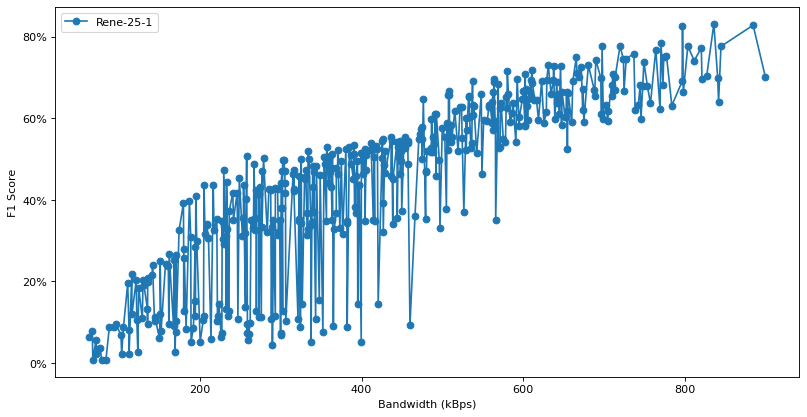

In [10]:
F1_Bandwidth_plot(bandwidth_f1)

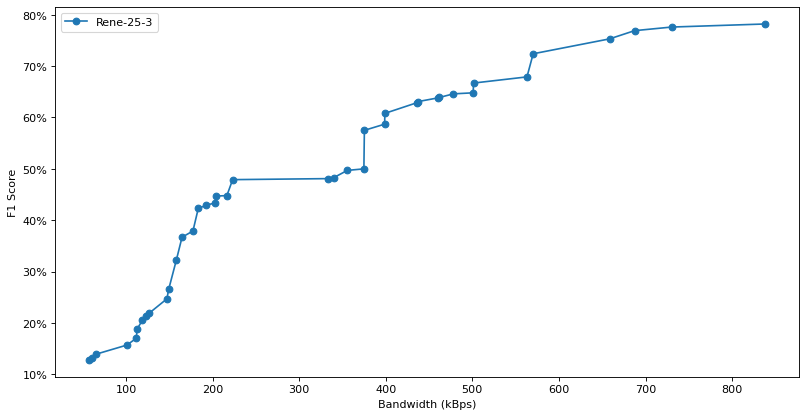

In [23]:
F1_Bandwidth_plot(bandwidth_f1_remove_fluc)